# Import needed libraries
To make things work ensure that you have this libraries installed.

In [1]:
%pip install split-folders imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25834 sha256=af28361a37c6e79e0dad5706dc208e775e6c010d335ad6ad6ff09d373d19cecc
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-ydqyqy2z
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/classification_models.git /tmp/pip-req-build-ydqyqy2z
  Resolved https://github.com/qubvel/classification_models.git to commit a0f006e05485a34ccf871c421279864b0ccd220b
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 797.0 kB/s eta 0:00:000:00:01
  Created wheel for image_classifiers: filename=image_classifiers-1.0.0-py3-none-any.whl size=20031 sha256=6ac7198cf4a318e96334a7a44f0371de4164ac11b8ad903b59392080cdf65f9d
  Stored in directory: /tmp/pip-ephem-wheel-cache-y9dvxjzt/wheels/f5/13/cb/b1dbd79043c5a389742e422859b0b663adcd7b5c220928c339
Successfully built image_classifiers
Note: you may need to restart the kernel to use updated packages.


In [48]:
import os
import numpy as np
import splitfolders
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from string import digits
from imutils import paths
from random import choices
from typing import Tuple, List
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.data import AUTOTUNE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import GRU, Dense, Bidirectional,  Reshape

from tensorflow.keras.layers import Conv2D, BatchNormalization, GlobalMaxPooling2D, Dense, Dropout, Input,
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.layers import Dropout, Concatenate, Flatten
from tensorflow.keras import Model

import keras
from classification_models.keras import Classifiers

# Data
The **Dataset** class is designed as a helper tool for loading and preparing image datasets for training machine learning models.

In [6]:
class Dataset:

    MAX_IMAGES_PER_GENRE = 5_000
    
    def __init__(self, path: str, output: str | None = None, ratio: Tuple[float, float, float] = (.70, .15, .15), split: bool = True, split_folders: bool = False, image_size: Tuple[int, int] = (224,224), batch_size: int = 8 , cache: bool = True):
        assert sum(ratio) == 1.0

        self.path = path
        self.labels = [name for name in tqdm(os.listdir(self.path)) if os.path.isdir(os.path.join(self.path, name))]
        
        self.cache = cache
        self.ratio = ratio
        
        self.output_path = output if output else f"./data-{''.join(choices(digits, k=5))}"
        
        self.train = os.path.sep.join([self.output_path, 'train'])
        self.val = os.path.sep.join([self.output_path, 'val'])
        self.test = os.path.sep.join([self.output_path, 'test'])
        
        self.image_size = image_size
        self.batch_size = batch_size
        
        assert split == True or split_folders == True or output is not None
        
        if split:
            self.__split()
        elif split_folders:
            self.__split_folder()
            
        self.__generate()
    
    def __split(self):
        tmp_ratio = (1.0 - self.ratio[0])
        val_test_ratio = self.ratio[1] / tmp_ratio
        
        def get_genres(path):
            genres = {}
            for image_path in tqdm(list(paths.list_images(path))):
                genre = os.path.basename(os.path.dirname(image_path))

                if genre not in genres:
                    genres[genre] = []
                
                if len(genres[genre]) >= Dataset.MAX_IMAGES_PER_GENRE:
                    continue
                
                genres[genre].append(image_path)
            
            return genres

        
        def split_genre(genre):
            train, tmp = train_test_split(genre, test_size=tmp_ratio, random_state=42)
            test, val = train_test_split(tmp, test_size=val_test_ratio, random_state=42)
            
            return train, val, test
        
        self.train, self.val, self.test = [], [], []
        genres = get_genres(self.path)
        for genre in genres.values():
            train, val, test = split_genre(genre)
            self.train.extend(train)
            self.val.extend(val)
            self.test.extend(test)
    
        np.random.shuffle(self.train)
        np.random.shuffle(self.val)
        np.random.shuffle(self.test)
    
    def __split_folder(self):
        splitfolders.ratio(self.path, output=self.output_path, seed=42, ratio=self.ratio, group_prefix=None)
    
    def __generate(self):
        def load_images(image_path):
            image = tf.io.read_file(image_path)
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)
            image = tf.image.resize(image, self.image_size)
            
            label = tf.strings.split(image_path, os.path.sep)[-2]
            label = tf.cast(tf.equal(self.labels, label), tf.int32)
    
            return (image, label)
        
        def get_paths(x):
            if isinstance(x, str):
                return paths.list_images(x)
            else:
                return x
        
        train_paths = get_paths(self.train)
        self.train_len = len(train_paths) // self.batch_size
        self.train = tf.data.Dataset.from_tensor_slices(train_paths)
        self.train = (self.train
            .shuffle(len(train_paths), reshuffle_each_iteration=True)
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(AUTOTUNE)
        )
        
        if self.cache:
            self.train = self.train.cache()
        
        val_paths = get_paths(self.val)
        self.val_len = len(val_paths) // self.batch_size
        self.val = tf.data.Dataset.from_tensor_slices(val_paths)
        self.val = (self.val
            .shuffle(len(val_paths))
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(AUTOTUNE)
        )
        
        if self.cache:
            self.val = val.train.cache()
        
        test_paths = get_paths(self.test)
        self.test_len = len(test_paths) // self.batch_size
        self.test = tf.data.Dataset.from_tensor_slices(test_paths)
        self.test = (self.test
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .batch(self.batch_size)
            .prefetch(AUTOTUNE)
        )
        
        if self.cache:
            self.test = self.test.cache()

# Helper functions
The following functions are helpful tools for visualising model training progress and evaluating model performance through confusion matrix analysis.

In [7]:
def plot_history(history, metric: str = '', ylim: List[float] | None = None):
    h = history.history
    plt.figure(figsize=(15,5))
    plt.plot(h[metric])
    plt.plot(h[f'val_{metric}'])
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend([metric, f'val_{metric}'], loc='upper left')
    if ylim:
        axes = plt.gca()
        axes.set_ylim(ylim)
    plt.show()
    
def show_confusion_matrix(y_true, y_pred, labels: List[str] = []):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(labels), len(labels)))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Bi-GRU 
The **build_model** function is a utility designed to construct and compile a model. The **STFT** and **Mel Spectrogram** are used to learn this model.

In [23]:
def build_BIGRU_model(height=224, width=224, channels=3):
    input_shape = (height, width, channels)
    
    inputs = Input(shape=input_shape)
    reshaped = Reshape((width, height * channels))(inputs)
    bi_gru = Bidirectional(GRU(256, return_sequences=True))(reshaped)
    bi_gru = tf.keras.layers.Flatten()(bi_gru)
    dense = Dense(256, activation='elu')(bi_gru)
    
    model = Model(inputs=inputs, outputs=dense)
    
    return model

# Resnet18

In [50]:
def build_RESNET_model(input_shape=(224, 224, 3)):
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    
    base_model = ResNet18(input_shape=input_shape, weights='imagenet', include_top=False)
    x = base_model.output
    x = GlobalMaxPooling2D(keepdims=True)(x)
    x = tf.keras.layers.Flatten()(x) 
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    
    return model

In [51]:
def build_combined_model(height=224, width=224, channels=3, genres=10):
    input_shape = (height, width, channels)
    
    resnet_model = build_RESNET_model(input_shape=input_shape)
    bigru_model = build_BIGRU_model(height=height, width=width, channels=channels)
    
    combined_input = Input(shape=input_shape)
    resnet_output = resnet_model(combined_input)
    bigru_output = bigru_model(combined_input)
    
    combined_output = Concatenate()([resnet_output, bigru_output])
    final_output = Dropout(0.5)(combined_output)
    final_output = Dense(genres, activation='softmax')(final_output)
    
    model = Model(inputs=combined_input, outputs=final_output)
    
    return model

# STFT

In [13]:
batch_size = 32
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/stft', batch_size=batch_size, cache=False)

100%|██████████| 4995/4995 [00:00<00:00, 264093.64it/s]


In [52]:
model = build_combined_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_59"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_55       │ (None, 256)       │ 11,319,241 │ input_layer_7[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_57       │ (None, 256)       │ 30,788,864 │ input_layer_7[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 512)       │          0 │ functional_55[0]… │
│ (Concatenate)       │                   │            │ functional_57[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 512)       │          0 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 10)        │      5,130 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,113,235 (160.65 MB)

 Trainable params: 42,104,781 (160.62 MB)

 Non-trainable params: 8,454 (33.02 KB)

In [53]:
epochs = 30

history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1)

Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 248ms/step - accuracy: 0.2185 - loss: 4.0379 - val_accuracy: 0.4592 - val_loss: 1.5036
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 243ms/step - accuracy: 0.5237 - loss: 1.5083 - val_accuracy: 0.5199 - val_loss: 1.4831
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step - accuracy: 0.6461 - loss: 1.0486 - val_accuracy: 0.5323 - val_loss: 1.5019
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 239ms/step - accuracy: 0.7368 - loss: 0.7377 - val_accuracy: 0.5076 - val_loss: 1.5096
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 242ms/step - accuracy: 0.8016 - loss: 0.5527 - val_accuracy: 0.5296 - val_loss: 1.4803
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step - accuracy: 0.8648 - loss: 0.3858 - val_accuracy: 0.4979 - val_loss: 1.6038
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 240ms/step - accuracy: 0.9207 - loss: 0.2454 - val_accuracy: 0.5406 - val_loss: 1.4034
Epoch 8/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 240ms/step - accuracy: 0.9469 - loss: 0

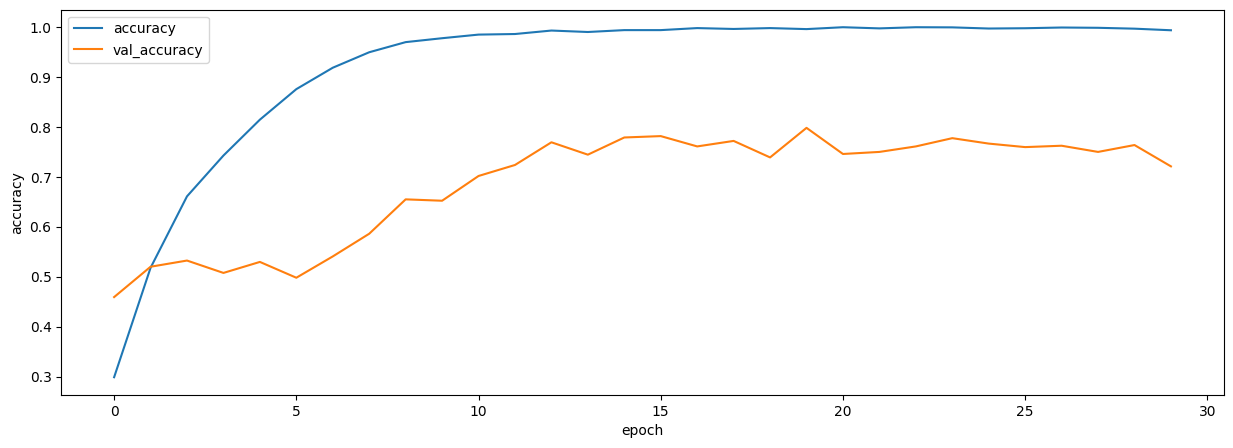

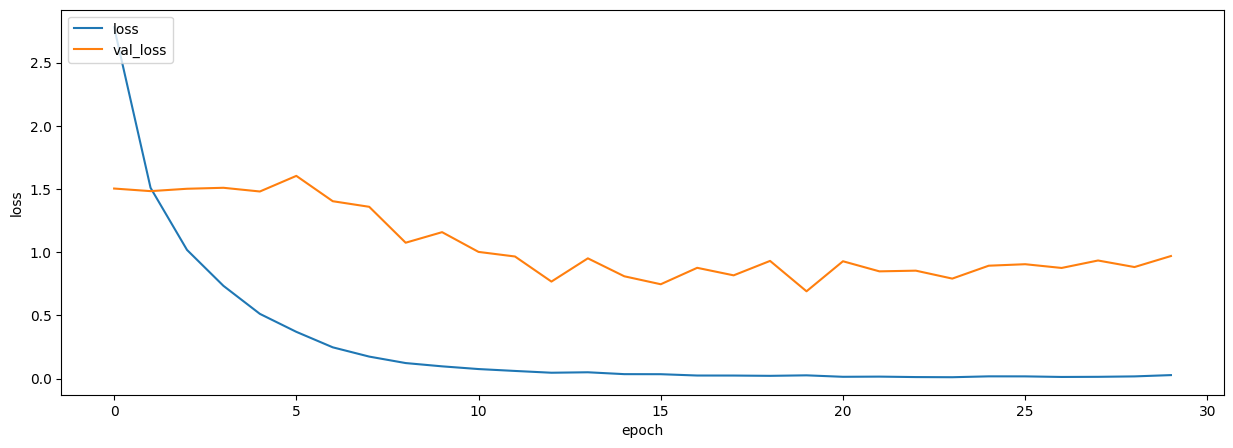

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.7274 - loss: 1.0337
Accuracy: 0.742323100566864
Loss: 0.9335432052612305
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step


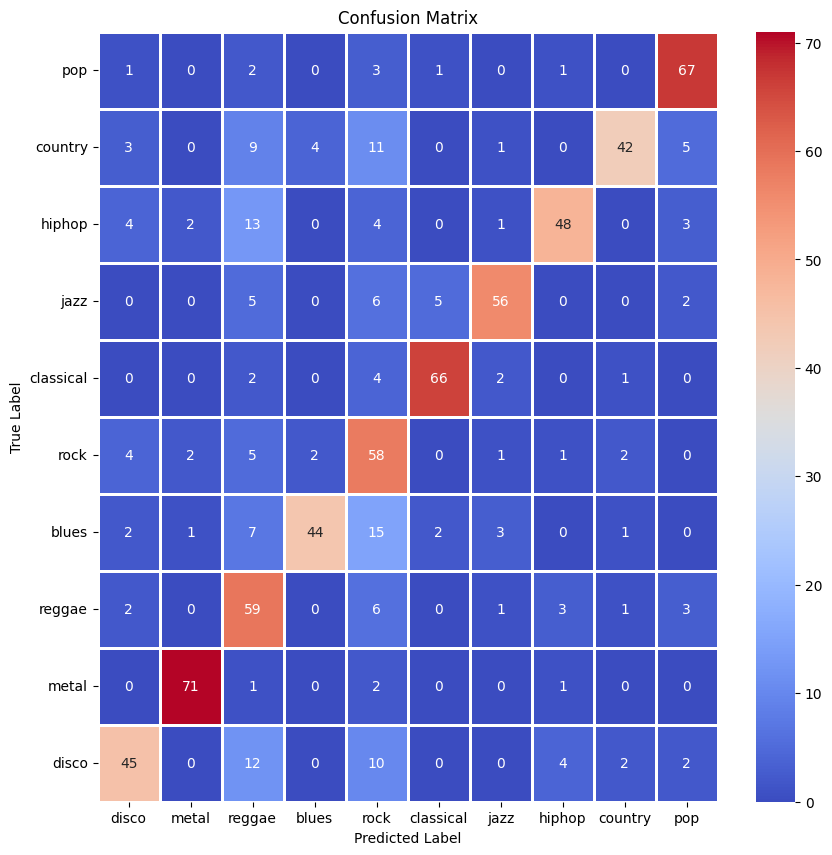

              precision    recall  f1-score   support

           0       0.74      0.60      0.66        75
           1       0.93      0.95      0.94        75
           2       0.51      0.79      0.62        75
           3       0.88      0.59      0.70        75
           4       0.49      0.77      0.60        75
           5       0.89      0.88      0.89        75
           6       0.86      0.76      0.81        74
           7       0.83      0.64      0.72        75
           8       0.86      0.56      0.68        75
           9       0.82      0.89      0.85        75

    accuracy                           0.74       749
   macro avg       0.78      0.74      0.75       749
weighted avg       0.78      0.74      0.75       749



In [54]:
plot_history(history, metric='accuracy')
plot_history(history, metric='loss')

evaluation = model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

y_pred = model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))

# Mel-Spectrogram

In [55]:
batch_size = 32
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/mel_spectrogram', batch_size=batch_size, cache=False)

100%|██████████| 4995/4995 [00:00<00:00, 230786.29it/s]


In [56]:
model = build_combined_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_67"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_63       │ (None, 256)       │ 11,319,241 │ input_layer_9[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_65       │ (None, 256)       │ 30,788,864 │ input_layer_9[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 512)       │          0 │ functional_63[0]… │
│ (Concatenate)       │                   │            │ functional_65[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 512)       │          0 │ concatenate_4[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 10)        │      5,130 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 42,113,235 (160.65 MB)

 Trainable params: 42,104,781 (160.62 MB)

 Non-trainable params: 8,454 (33.02 KB)

In [57]:
epochs = 30

history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1)

Epoch 1/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 253ms/step - accuracy: 0.2001 - loss: 3.7492 - val_accuracy: 0.3913 - val_loss: 1.6379
Epoch 2/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 242ms/step - accuracy: 0.4827 - loss: 1.5427 - val_accuracy: 0.3838 - val_loss: 1.6505
Epoch 3/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 237ms/step - accuracy: 0.5897 - loss: 1.1981 - val_accuracy: 0.5144 - val_loss: 1.4352
Epoch 4/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 240ms/step - accuracy: 0.7055 - loss: 0.8599 - val_accuracy: 0.4993 - val_loss: 1.4379
Epoch 5/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 241ms/step - accuracy: 0.7595 - loss: 0.6892 - val_accuracy: 0.4663 - val_loss: 1.7184
Epoch 6/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 239ms/step - accuracy: 0.8351 - loss: 0.4848 - val_accuracy: 0.2737 - val_loss: 3.2790
Epoch 7/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 239ms/step - accuracy: 0.8786 - loss: 0.3712 - val_accuracy: 0.4250 - val_loss: 2.6694
Epoch 8/30
108/108 ━━━━━━━━━━━━━━━━━━━━ 26s 240ms/step - accuracy: 0.9106 - loss: 0

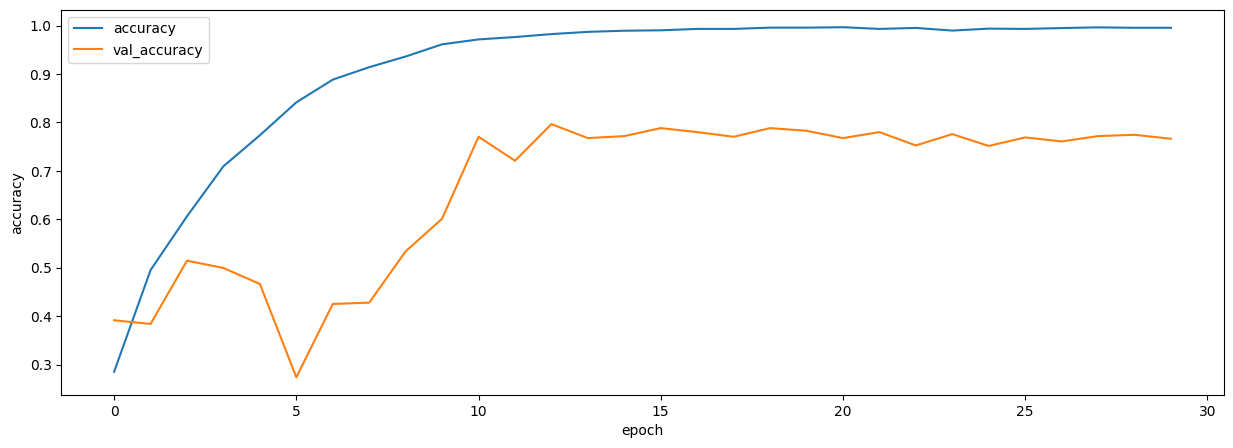

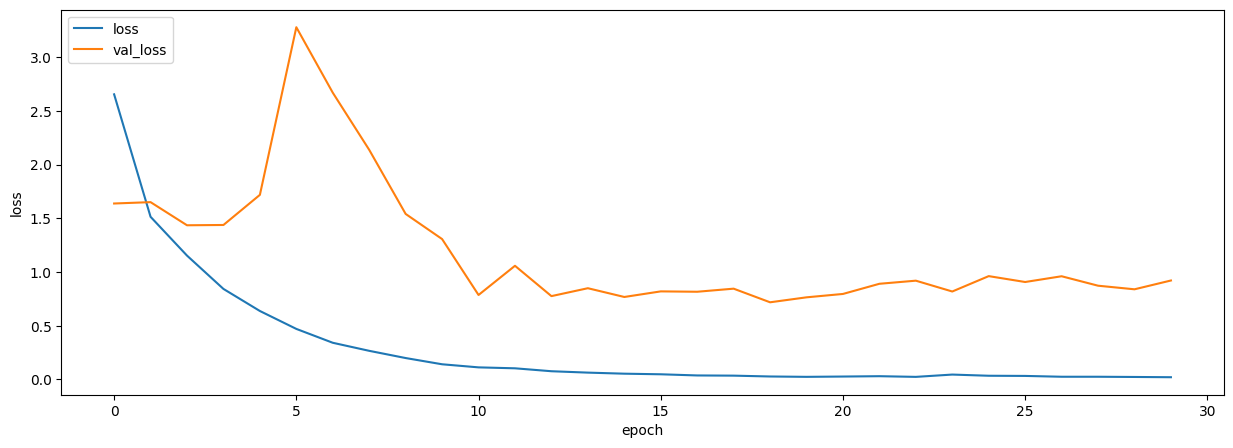

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.7620 - loss: 0.9493
Accuracy: 0.7449933290481567
Loss: 1.0220972299575806
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step


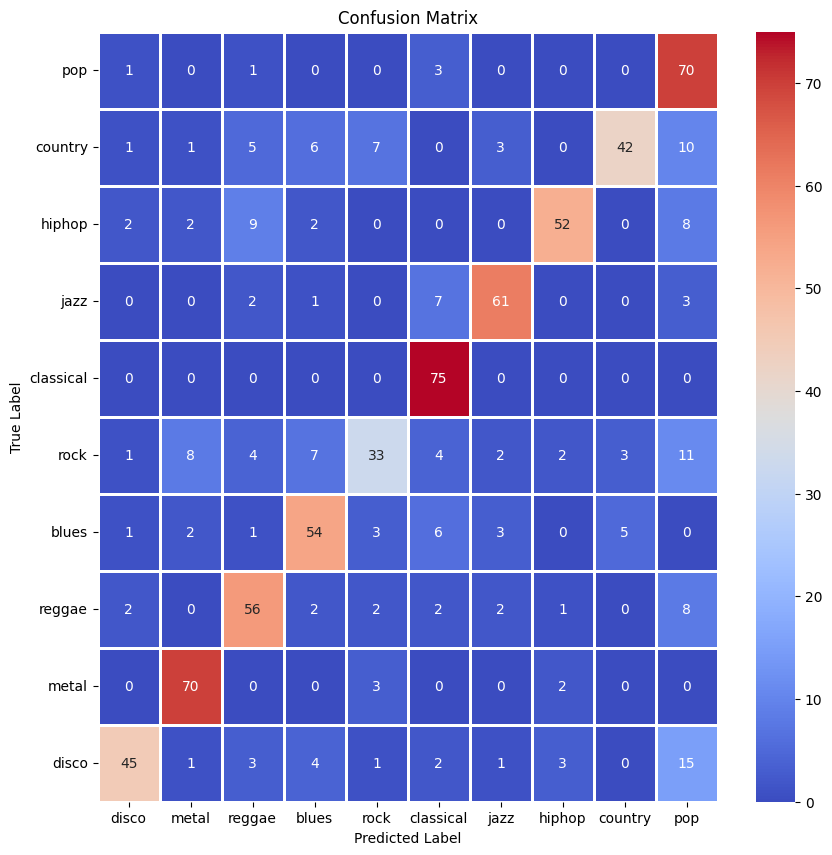

              precision    recall  f1-score   support

           0       0.85      0.60      0.70        75
           1       0.83      0.93      0.88        75
           2       0.69      0.75      0.72        75
           3       0.71      0.72      0.72        75
           4       0.67      0.44      0.53        75
           5       0.76      1.00      0.86        75
           6       0.85      0.82      0.84        74
           7       0.87      0.69      0.77        75
           8       0.84      0.56      0.67        75
           9       0.56      0.93      0.70        75

    accuracy                           0.74       749
   macro avg       0.76      0.75      0.74       749
weighted avg       0.76      0.74      0.74       749



In [58]:
plot_history(history, metric='accuracy')
plot_history(history, metric='loss')

evaluation = model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

y_pred = model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))